# Dimensionality Reduction Workshop - CORRECTION

## Example : hurricane meteorological data

Sophie Giffard-Roisin (sophie.giffard@colorado.edu)

## Introduction
This is an initiation to introduce dimensionality reduction and get you to know how it works.

We will use a real hurricane meteorological dataset, which typical goal is to estimate the current stength of the hurricane or to predict its evolution. 
<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/all_storms_since1979_IBTrRACKS_newcats.png?raw=true" width="70%">
<div style="text-align: center">Database: tropical/extra-tropical storm tracks since 1979. Dots = initial position, color = maximal storm strength according to the Saffir-Simpson scale.</div>


### Requirements

* numpy  
* matplotlib
* pandas 
* scikit-learn   

In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename)
y_df = data['windspeed']
X_df = data.drop(['windspeed', 'stormid', 'instant_t'], axis=1)
X_df.head(5)

,latitude,longitude,hemisphere,Jday_predictor,initial_max_wind,max_wind_change_12h,basin,nature,dist2land,z_0_0,...,v_10_1,v_10_2,v_10_3,v_10_4,v_10_5,v_10_6,v_10_7,v_10_8,v_10_9,v_10_10
0,11.0,-95.5,1,5.433485e-08,25,0,3,0,528,114352.8,...,10.832,7.127,4.458,2.616,-2.283,-10.479,-18.107,-19.628,-10.797,-3.613
1,11.0,-96.2,1,5.433485e-08,25,5,3,0,516,114196.2,...,10.569,7.479,5.263,1.768,-0.883,-6.414,-12.612,-19.834,-14.629,-4.346
2,11.0,-96.9,1,5.433485e-08,25,5,3,0,516,114387.3,...,11.471,8.405,3.816,3.277,1.500,-2.509,-9.280,-18.518,-19.831,-9.238
3,11.3,-97.6,1,5.433485e-08,25,0,3,0,493,114082.5,...,8.833,11.003,7.783,4.200,1.796,-0.258,-3.897,-10.931,-17.617,-10.104
4,11.8,-98.0,1,5.433485e-08,25,0,3,0,451,114382.4,...,5.326,12.050,11.609,6.832,2.319,-3.118,-8.629,-12.508,-11.779,-3.977


For the meaning of the columns, refer to this notebook https://github.com/ramp-kits/storm_forecast/blob/master/storm_forecast_starting_kit.ipynb

Load also the test data:

In [3]:
test_filename = 'data/test.csv'
data_test = pd.read_csv(train_filename)
y_df_test = data_test['windspeed']
X_df_test = data_test.drop(['windspeed', 'stormid', 'instant_t'], axis=1)

## Standardize your data

In [4]:
from sklearn.preprocessing import StandardScaler

X_df = X_df.astype(float)
X_df_test = X_df.astype(float)

For all features, transform your data such that mean=0 and std=1 (on the training data), and use the same parameters for transforming the test data also. 

In [5]:
scaler=StandardScaler().fit(X_df)
X_df=scaler.transform(X_df)
X_df_test=scaler.transform(X_df_test)

## Principal Component analysis

Use PCA and transform the training data such as to conserve 95% of the explained variance of the data. Then, transform the test data accordingly. (Look at sklearn.decomposition.PCA for how to use it)

In [6]:
from sklearn.decomposition import PCA

1) Fit the pca with the training features:

In [8]:
pca = PCA(svd_solver='full')
pca.fit(X_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

2) Calculate the cumulative explained variance (you can use the np.cumsum function) and determine how many modes are necessary in order to keep 95% of the explained variance:

In [9]:
cumsum_var = np.cumsum(pca.explained_variance_)
thresh = 0.95 * float(max(cumsum_var) - min(cumsum_var)) + min(cumsum_var)
for c, i in zip(cumsum_var, range(len(cumsum_var))):
    if c > thresh:
        num_modes = i
        break

Now we can plot it:

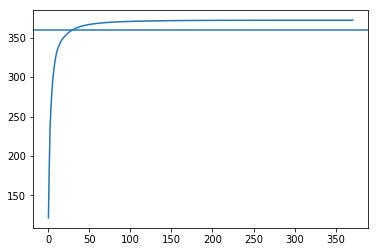

Number of modes:29


In [10]:
plt.figure()
plt.plot(cumsum_var)
plt.axhline(thresh, xmin=0, xmax=len(pca.explained_variance_))
plt.show()
print('Number of modes:' + str(num_modes))

3) Create a reduced feature matrix X_df_pca (and then X_df_test_pca) using the number of modes found. You may need to create a second 'pca' instance.

In [12]:
pca = PCA(svd_solver='full', n_components=num_modes)
pca.fit(X_df)
X_df_pca=pca.transform(X_df)
X_df_test_pca=pca.transform(X_df_test)
print('Number of feature dimensions:'+ str(len(X_df_pca[0])) )

Number of feature dimensions:29


We can now plot the first two modes of the X_df_pca, with y as color label.

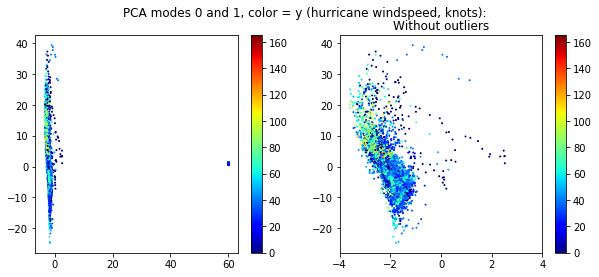

In [13]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)
plt.scatter(np.transpose(X_df_pca)[0], np.transpose(X_df_pca)[1], c=y_df, s=1, cmap='jet')
plt.colorbar()

ax2 = plt.subplot(1,2,2)
plt.scatter(np.transpose(X_df_pca)[0], np.transpose(X_df_pca)[1], c=y_df, s=1, cmap='jet')
ax2.set_title('Without outliers')
plt.xlim([-4,4])
col = plt.colorbar()
t = plt.suptitle('PCA modes 0 and 1, color = y (hurricane windspeed, knots):')

## Non-linear methods: Multidimensional scaling (MDS) and Isomap

The MDS performs a non-linear dimentionality reduction  by preserving the (Eucliean) distances between points. The isomap is an extended version of the MDS where the geodesic distances are preserved.

In [14]:
from sklearn.manifold import MDS, Isomap
Nsamples = 1000
X_df_small = X_df[:Nsamples]

First, apply the MDS to the training data X_df with 2 components and save it as X_df_MDS. Do the same thing with isomap and create a X_df_isomap. Verify that their shape are Nb_samples x 2 . Use less samples (1000) in order to reduce computing time.

In [16]:
embedding_MDS = MDS(n_components=2)
X_df_MDS = embedding_MDS.fit_transform(X_df_small)

embedding_isomap= Isomap(n_components=2)
X_df_isomap = embedding_isomap.fit_transform(X_df_small)

print(X_df_MDS.shape)

(1000, 2)


And now we can plot them.

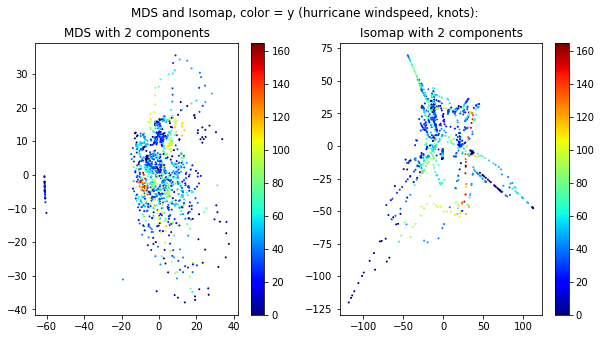

In [80]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
ax.set_title('MDS with 2 components')
plt.scatter(np.transpose(X_df_MDS)[0], np.transpose(X_df_MDS)[1], c=y_df[:Nsamples], s=1, cmap='jet')
c=plt.colorbar()

ax2 = plt.subplot(1,2,2)
ax2.set_title('Isomap with 2 components')
plt.scatter(np.transpose(X_df_isomap)[0], np.transpose(X_df_isomap)[1], c=y_df[:Nsamples], s=1, cmap='jet')
c2=plt.colorbar()


t = plt.suptitle('MDS and Isomap, color = y (hurricane windspeed, knots):')

On the Isomap, we can maybe distinguish the trajectories of individual hurricanes (one hurricane has between 5 to 100 time steps, every time step is a different point here).

## ARD : Regression with automatic dim. reduction

Choose a smaller number of samples in order to reduce the computational time... to be noticed, there are faster versions available here : https://github.com/AmazaspShumik/sklearn-bayes 

In [17]:
from sklearn.linear_model import ARDRegression
Nsamples = 500

Fit an ARD instance with part of the training samples (ex. 500 - you can shuffle them to have a better result):

In [18]:
clf = ARDRegression(compute_score=True)
clf.fit(X_df[:Nsamples], y_df[:Nsamples])

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)

We can plot the values of the feature weights and their histogram.

No handles with labels found to put in legend.


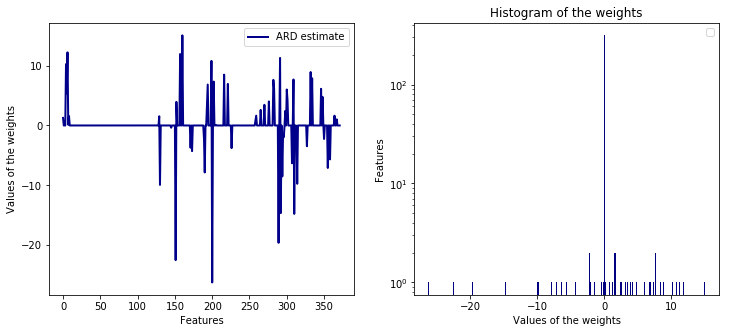

In [97]:
plt.figure(figsize=(12, 5))
plt.title("Weights of the model")
ax = plt.subplot(1,2,1)
plt.plot(clf.coef_, color='darkblue', linestyle='-', linewidth=2,
         label="ARD estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

ax2 = plt.subplot(1,2,2)
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=len(X_df[0]), color='navy', log=True)
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

You can see on the first figure what are the important features for this task. On the second, you can see that a lot of weights are 0.


In [19]:
from sklearn.metrics import mean_absolute_error

Now, estimate the mean absolute error on the test set:

In [20]:
y_est = clf.predict(X_df_test)
mae_ARD = mean_absolute_error(y_df_test, y_est)
print(mae_ARD)

26.37772185942272


## Other methods

You can play with other dimensionality reduction on the same dataset (or on others) by looking at:

In [19]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim # for deciding whether to use it or not
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import SpectralEmbedding